# ASX Short Interest Signal

## Import Libraries

In [15]:
import pandas as pd
import datetime as dt
import tabula
import sys, subprocess
from pandas.tseries.offsets import BDay
import yfinance as yf
import time
import numpy as np
import tabula, concurrent.futures, functools
import concurrent.futures
import time, random, concurrent.futures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm


## Import Data
### Extracting and cleaning 52 weeks of ASX short interest data from ASIC. 

In [2]:
# --------- CONFIG ----------
WEEKS_TO_LOAD = 796
BASE = "https://download.asic.gov.au/short-selling/RR{datestr}-001-SSDailyAggShortPos.pdf"

# --------- Helpers ----------
def _norm_cols(cols):
    return [c.strip().lower().replace("\n", " ").replace("  ", " ") for c in cols]

def _num(s):
    return pd.to_numeric(pd.Series(s).astype(str).str.replace(",", "").str.strip(), errors="coerce")

def _is_ticker(x):
    """ASX tickers are 1–6 alphanumeric chars (allow '.'), no spaces."""
    if pd.isna(x): return False
    s = str(x).strip()
    if s.lower().startswith("product code"): return False
    if " " in s: return False
    return 1 <= len(s.replace(".", "")) <= 6 and s.replace(".", "").isalnum()

def _rename_clean_one(df):
    raw, norm = list(df.columns), _norm_cols(df.columns)
    cmap = {}
    for i, c in enumerate(norm):
        if c.startswith("product code"): cmap[raw[i]] = "Ticker"
        elif c.startswith("product"): cmap[raw[i]] = "Company"
        elif "reported short position" in c and "reported as short" not in c:
            cmap[raw[i]] = "Short Positions"
        elif "total product in issue" in c and "reported as short" not in c:
            cmap[raw[i]] = "Total Volume"
        elif "% of total product in issue reported as short positions" in c or c.endswith("short positions"):
            cmap[raw[i]] = "Shorts (%)"
    df = df.rename(columns=cmap)
    keep = ["Company","Ticker","Short Positions","Total Volume","Shorts (%)"]
    df = df[[c for c in keep if c in df.columns]].copy()
    if "Ticker" in df.columns:
        df = df[df["Ticker"].apply(_is_ticker)]
    if "Short Positions" in df.columns:
        df["Short Positions"] = _num(df["Short Positions"])
    if "Total Volume" in df.columns:
        df["Total Volume"] = _num(df["Total Volume"])
    if "Shorts (%)" in df.columns:
        df["Shorts (%)"] = pd.to_numeric(df["Shorts (%)"], errors="coerce")
    if "Shorts (%)" not in df.columns and {"Short Positions","Total Volume"}.issubset(df.columns):
        df["Shorts (%)"] = (df["Short Positions"] / df["Total Volume"]) * 100
    for col in keep:
        if col not in df.columns: df[col] = pd.NA
    return df[keep]

def _read_all_tables(url):
    for kw in (dict(lattice=True), dict(stream=True)):
        try:
            t = tabula.read_pdf(url, pages="all", multiple_tables=True, **kw)
            if t and len(t) > 0:
                return t
        except Exception:
            pass
    return []

def most_recent_friday(ref_date=None):
    if ref_date is None:
        ref_date = dt.date.today()
    offset = (ref_date.weekday() - 4) % 7
    return ref_date - dt.timedelta(days=offset)

def fetch_eow_for_friday(friday_date: dt.date, max_back_days=6) -> pd.DataFrame:
    for delta in range(0, max_back_days+1):
        day = friday_date - dt.timedelta(days=delta)
        ds = day.strftime("%Y%m%d")
        url = BASE.format(datestr=ds)
        tables = _read_all_tables(url)
        if not tables: continue
        cleaned = []
        for t in tables:
            if isinstance(t, pd.DataFrame) and len(t) >= 4 and len(t) > 0:
                cleaned.append(_rename_clean_one(t.dropna(how="all")))
        if not cleaned: continue
        out = pd.concat(cleaned, ignore_index=True).drop_duplicates()
        if not out.empty:
            release_dt = pd.to_datetime(ds, format="%Y%m%d")
            asof_dt = (release_dt - BDay(4)).normalize()
            out.insert(0, "Date", asof_dt)
            out.insert(1, "ReleaseDate", release_dt)
            return out
    return pd.DataFrame()

# --------- MAIN ----------
anchor_friday = most_recent_friday()
fridays = [anchor_friday - dt.timedelta(weeks=k) for k in range(WEEKS_TO_LOAD)]

with concurrent.futures.ThreadPoolExecutor(max_workers=6) as ex:
    frames = list(ex.map(fetch_eow_for_friday, fridays))

frames = [f for f in frames if not f.empty]
if not frames:
    raise RuntimeError("No ASIC EOW reports could be fetched. Check internet/Java (tabula).")

hist_df = (pd.concat(frames, ignore_index=True)
              .drop_duplicates(subset=["Date","Ticker"])
              .sort_values(["Date","Ticker"])
              .reset_index(drop=True))

# ---------- Filter: Keep only equities (ORDINARY shares) ----------
before = len(hist_df)
hist_df = hist_df[hist_df["Company"].str.contains("ORDINARY", case=False, na=False)]
after = len(hist_df)
print(f"Filtered out {before - after} non-ordinary securities (bonds, ETFs, hybrids).")

# ---------- Summary ----------
print(f"\nLoaded {hist_df['Date'].dt.date.nunique()} as-of dates, "
      f"{hist_df['Ticker'].nunique()} unique tickers, "
      f"{len(hist_df)} total rows (equities only).")

Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'


Filtered out 63104 non-ordinary securities (bonds, ETFs, hybrids).

Loaded 794 as-of dates, 2460 unique tickers, 370271 total rows (equities only).


In [3]:
# ---------- Preview ----------
print("\nPreview of cleaned ASIC short data:")
display(
    hist_df.tail(10)[
        ["Date", "ReleaseDate", "Ticker", "Company",
         "Short Positions", "Total Volume", "Shorts (%)"]
    ]
)


Preview of cleaned ASIC short data:


,Date,ReleaseDate,Ticker,Company,Short Positions,Total Volume,Shorts (%)
433358,2025-08-22,2025-08-28,WHC,WHITEHAVEN COAL ORDINARY,32688685,832423807,3.93
433359,2025-08-22,2025-08-28,WHK,WHITEHAWK LIMITED ORDINARY,69610,876984963,0.01
433360,2025-08-22,2025-08-28,WJL,WEBJET GROUP LIMITED ORDINARY,1603102,392530357,0.41
433361,2025-08-22,2025-08-28,WMG,WESTERN MINES ORDINARY,292,97188344,0.00
433362,2025-08-22,2025-08-28,WOR,WORLEY LIMITED ORDINARY,1154996,516038800,0.22
433363,2025-08-22,2025-08-28,WOW,WOOLWORTHS GROUP LTD ORDINARY,14474023,1221595333,1.18
433365,2025-08-22,2025-08-28,WTC,WISETECH GLOBAL LTD ORDINARY,4068174,334622986,1.22
433370,2025-08-22,2025-08-28,XRO,XERO LTD ORDINARY,1890673,165381624,1.14
433373,2025-08-22,2025-08-28,YAL,YANCOAL AUST LTD ORDINARY,33371106,1320439437,2.53
433374,2025-08-22,2025-08-28,ZIP,ZIP CO LTD.. ORDINARY,40428382,1290833227,3.13


### Add share price at release date and trading date as well as free float and SI (% of free float)

In [4]:
# ---------- Add Symbol + Normalized dates ----------
work = hist_df.copy()
work["Symbol"] = work["Ticker"].str.upper().str.strip() + ".AX"
work["Date_norm"] = pd.to_datetime(work["Date"]).dt.normalize()
work["ReleaseDate_norm"] = pd.to_datetime(work["ReleaseDate"]).dt.normalize()

syms = sorted(work["Symbol"].dropna().unique())
start = pd.to_datetime(work[["Date_norm","ReleaseDate_norm"]].min().min()) - pd.Timedelta(days=2)
end   = pd.to_datetime(work[["Date_norm","ReleaseDate_norm"]].max().max()) + pd.Timedelta(days=5)

# ---------- Float snapshot with fallback ----------
def _safe_float_info(sym: str) -> dict:
    out = {"Symbol": sym, "floatShares": np.nan, "sharesOutstanding": np.nan, "heldPercentInsiders": np.nan}
    try:
        tkr = yf.Ticker(sym)
        fi = getattr(tkr, "fast_info", None)
        if fi:
            out["floatShares"] = getattr(fi, "shares_float", np.nan)
            out["sharesOutstanding"] = getattr(fi, "shares_outstanding", np.nan)
        if pd.isna(out["floatShares"]) or pd.isna(out["sharesOutstanding"]):
            try:
                info = tkr.get_info()
            except Exception:
                info = getattr(tkr, "info", {}) or {}
            if info:
                fs = info.get("floatShares")
                so = info.get("sharesOutstanding") or info.get("impliedSharesOutstanding")
                hpi = info.get("heldPercentInsiders")
                if fs not in (None, ""):
                    out["floatShares"] = float(fs)
                if so not in (None, ""):
                    out["sharesOutstanding"] = float(so)
                if isinstance(hpi, (int, float)):
                    out["heldPercentInsiders"] = float(hpi)
    except Exception:
        pass
    return out

float_df = pd.DataFrame(_safe_float_info(s) for s in syms)
work = work.merge(float_df, on="Symbol", how="left")

# ---------- Free Float Estimate ----------
ff_from_insiders = work["sharesOutstanding"] * (1 - work["heldPercentInsiders"].fillna(0))
ff_candidates = pd.concat([work["floatShares"], ff_from_insiders], axis=1)
work["Date Free Float"] = ff_candidates.max(axis=1)

# ---------- Short Interest as % of free float ----------
m_ff = work["Short Positions"].notna() & work["Date Free Float"].gt(0)
work.loc[m_ff, "Shorts (Free Float %)"] = 100 * work.loc[m_ff, "Short Positions"] / work.loc[m_ff, "Date Free Float"]

# ---------- Price history (batch to reduce errors) ----------
batch_size = 50
price_frames = []
for i in range(0, len(syms), batch_size):
    batch = syms[i:i+batch_size]
    try:
        data = yf.download(
            batch,
            start=start.strftime("%Y-%m-%d"),
            end=end.strftime("%Y-%m-%d"),
            auto_adjust=False,
            progress=False,
            threads=True,
        )
        if "Close" in data.columns:   # Multi-ticker DataFrame
            data = data["Close"]
        elif isinstance(data, pd.Series):  # Single ticker fallback
            data = data.to_frame(name=batch[0])
        data.index = pd.to_datetime(data.index).normalize()
        price_frames.append(data)
        print(f"✓ Batch {i//batch_size+1}: {len(batch)} tickers")
    except Exception as e:
        print(f"⚠️ Batch {i//batch_size+1} failed: {e}")

if price_frames:
    prices = pd.concat(price_frames, axis=1).sort_index()
else:
    prices = pd.DataFrame()

# ---------- Align prices to Date & ReleaseDate ----------
asof_idx = pd.to_datetime(work["Date_norm"].unique())
rel_idx  = pd.to_datetime(work["ReleaseDate_norm"].unique())

asof_price = prices.reindex(asof_idx, method="bfill").stack().reset_index()
asof_price.columns = ["Date_norm","Symbol","Date Share Price"]

rel_price = prices.reindex(rel_idx, method="bfill").stack().reset_index()
rel_price.columns = ["ReleaseDate_norm","Symbol","Release Date Share Price"]

# ---------- Merge back ----------
hist_df = (work
    .merge(asof_price, on=["Date_norm","Symbol"], how="left")
    .merge(rel_price, on=["ReleaseDate_norm","Symbol"], how="left")
    .drop(columns=["Symbol","Date_norm","ReleaseDate_norm",
                   "floatShares","sharesOutstanding","heldPercentInsiders"])
    .sort_values(["Date","Ticker"])
    .reset_index(drop=True)
)

# ---------- Drop bad rows (require all critical fields) ----------
critical_cols = ["Date Share Price","Release Date Share Price","Date Free Float","Shorts (Free Float %)"]
hist_df = hist_df.dropna(subset=critical_cols)

# ---------- Preview ----------
print("Final cleaned dataset:")
print("Prices on Date:", hist_df["Date Share Price"].notna().sum(), "/", len(hist_df))
print("Prices on ReleaseDate:", hist_df["Release Date Share Price"].notna().sum(), "/", len(hist_df))
print("Free float present:", hist_df["Date Free Float"].notna().sum(), "/", len(hist_df))
print(">100% after fix:", (hist_df["Shorts (Free Float %)"] > 100).sum())

display(hist_df.head(12)[[
    "Date","ReleaseDate","Ticker","Company",
    "Short Positions","Total Volume","Shorts (%)",
    "Date Free Float","Shorts (Free Float %)",
    "Date Share Price","Release Date Share Price"
]])

HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 
HTTP Error 404: 

17 Failed downloads:
['ABC.AX', 'ACB.AX', 'ABA.AX', '8EC.AX', '92E.AX', '9SP.AX', '2BE.AX', '4CE.AX', 'AB1.AX', 'A2B.AX', 'ABR.AX', 'A40.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 1: 50 tickers



14 Failed downloads:
['ADU.AX', 'AEO.AX', 'AGF.AX', 'AEK.AX', 'ACG.AX', 'AED.AX', 'AFY.AX', 'AEJ.AX', 'AGK.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['ADJ.AX', 'ADA.AX', 'AFJ.AX', 'ACN.AX', 'AGJ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 2: 50 tickers



18 Failed downloads:
['AIK.AX', 'AKK.AX', 'AHD.AX', 'AIX.AX', 'AHE.AX', 'AIO.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['AHQ.AX', 'AKI.AX', 'AJM.AX', 'AJC.AX', 'AHZ.AX', 'ALG.AX', 'AKE.AX', 'AIR.AX', 'AHG.AX', 'ALF.AX', 'AGS.AX', 'AHY.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 3: 50 tickers



19 Failed downloads:
['ANP.AX', 'AND.AX', 'AML.AX', 'APD.AX', 'AMB.AX', 'APM.AX', 'ALU.AX', 'AMG.AX', 'ANW.AX', 'AOP.AX', 'ANA.AX', 'AOU.AX', 'APT.AX', 'API.AX', 'AMM.AX']: YFTzMissingError('possibly delisted; no timezone found')
['ALS.AX', 'AOC.AX', 'AOE.AX', 'APN.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')


✓ Batch 4: 50 tickers



13 Failed downloads:
['ATI.AX', 'ASZ.AX', 'AQA.AX', 'APY.AX', 'ARW.AX', 'AQP.AX', 'ARP.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['ASO.AX', 'ARQ.AX', 'ARM.AX', 'ATL.AX', 'AST.AX', 'ARE.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 5: 50 tickers



13 Failed downloads:
['AVX.AX', 'AVO.AX', 'AXO.AX', 'AXM.AX', 'AWB.AX', 'AYN.AX', 'AXA.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['AU8.AX', 'AWC.AX', 'AVZ.AX', 'AWV.AX', 'AYS.AX', 'AUT.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 6: 50 tickers



20 Failed downloads:
['AZO.AX', 'AZZ.AX', 'AZX.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['BEM.AX', 'BAU.AX', 'BAR.AX', 'BAF.AX', 'BDC.AX', 'AZT.AX', 'B2Y.AX', 'BDR.AX', 'AZS.AX', 'BAT.AX', 'BD1.AX', 'AZM.AX', 'BBX.AX', 'AZG.AX', 'BDA.AX', 'BAL.AX', 'AZH.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 7: 50 tickers



20 Failed downloads:
['BMB.AX', 'BPA.AX', 'BLR.AX', 'BKP.AX', 'BND.AX', 'BOW.AX', 'BKN.AX', 'BIG.AX', 'BOM.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['BNO.AX', 'BLD.AX', 'BLT.AX', 'BLK.AX', 'BID.AX', 'BIN.AX', 'BME.AX', 'BGS.AX', 'BLY.AX', 'BKL.AX', 'BLA.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 8: 50 tickers



21 Failed downloads:
['BRM.AX', 'BTU.AX', 'BRS.AX', 'BVA.AX', 'BTV.AX', 'BTT.AX', 'BPS.AX', 'BYR.AX', 'BRC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['BRV.AX', 'BSR.AX', 'BSE.AX', 'BYE.AX', 'BWX.AX', 'BTH.AX', 'BST.AX', 'BUD.AX', 'BSM.AX', 'BUL.AX', 'BZL.AX', 'BRB.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 9: 50 tickers



19 Failed downloads:
['CBX.AX', 'CEG.AX', 'CCC.AX', 'CAB.AX', 'CBB.AX', 'CAH.AX', 'CCU.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['CAS.AX', 'CE1.AX', 'CDY.AX', 'CAD.AX', 'CAI.AX', 'CAP.AX', 'CDD.AX', 'CBR.AX', 'CCZ.AX', 'CDV.AX', 'CAU.AX', 'CAJ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 10: 50 tickers



25 Failed downloads:
['CGH.AX', 'CIR.AX', 'CHP.AX', 'CLL.AX', 'CIG.AX', 'CIL.AX', 'CEY.AX', 'CGG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['CJO.AX', 'CHZ.AX', 'CLT.AX', 'CGA.AX', 'CGL.AX', 'CGC.AX', 'CL1.AX', 'CGB.AX', 'CHK.AX', 'CGM.AX', 'CIM.AX', 'CGN.AX', 'CLI.AX', 'CLQ.AX', 'CLH.AX', 'CFE.AX', 'CLF.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 11: 50 tickers



21 Failed downloads:
['COZ.AX', 'CMR.AX', 'CNK.AX', 'CPS.AX', 'CPB.AX', 'CO1.AX', 'CMV.AX', 'COU.AX', 'CNA.AX', 'CPL.AX', 'COK.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['CPH.AX', 'COE.AX', 'CNW.AX', 'CNL.AX', 'CMA.AX', 'CNX.AX', 'CNR.AX', 'CPZ.AX', 'COO.AX', 'CM8.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 12: 50 tickers



18 Failed downloads:
['CUA.AX', 'CRE.AX', 'CRZ.AX', 'CRK.AX', 'CR8.AX', 'CQT.AX', 'CWE.AX', 'CRG.AX', 'CRH.AX', 'CVO.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['CRW.AX', 'CRO.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['CSJ.AX', 'CSV.AX', 'CVT.AX', 'CSR.AX', 'CV1.AX', 'CTX.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 13: 50 tickers



17 Failed downloads:
['CXS.AX', 'CYU.AX', 'CXY.AX', 'CXB.AX', 'CXP.AX', 'CZA.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['DAU.AX', 'CZL.AX', 'DEG.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['DFM.AX', 'CZI.AX', 'DDD.AX', 'DEX.AX', 'CWN.AX', 'DDH.AX', 'DCN.AX', 'DCG.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 14: 50 tickers



21 Failed downloads:
['DTE.AX', 'DLS.AX', 'DOM.AX', 'DJS.AX', 'DSH.AX', 'DRK.AX', 'DRG.AX', 'DKO.AX', 'DML.AX', 'DKN.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['DOU.AX', 'DRM.AX', 'DSE.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['DLC.AX', 'DLX.AX', 'DTQ.AX', 'DGO.AX', 'DTS.AX', 'DTC.AX', 'DN8.AX', 'DRA.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 15: 50 tickers



23 Failed downloads:
['DYE.AX', 'EFG.AX', 'EGP.AX', 'ELM.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['EGS.AX', 'EGA.AX', 'ELK.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['E33.AX', 'DWS.AX', 'EHE.AX', 'ELO.AX', 'EEG.AX', 'EM1.AX', 'E2E.AX', 'EGN.AX', 'DVN.AX', 'EGO.AX', 'DW8.AX', 'E2M.AX', 'EAS.AX', 'ELX.AX', 'ECX.AX', 'EAR.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 16: 50 tickers



19 Failed downloads:
['EMX.AX', 'EUG.AX', 'EPG.AX', 'ESG.AX', 'EPT.AX', 'ESN.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['ESH.AX', 'EN1.AX', 'ERW.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['ENA.AX', 'EPW.AX', 'ESS.AX', 'ETE.AX', 'ESV.AX', 'EP1.AX', 'ERX.AX', 'EPD.AX', 'EUC.AX', 'ENE.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 17: 50 tickers



18 Failed downloads:
['EZE.AX', 'FCR.AX', 'FGE.AX', 'FAN.AX', 'EXC.AX', 'EXS.AX', 'EXE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['FGO.AX', 'FEL.AX', 'FDM.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['FEO.AX', 'FFF.AX', 'FGL.AX', 'FFX.AX', 'FFR.AX', 'EX1.AX', 'FFT.AX', 'EXU.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 18: 50 tickers



19 Failed downloads:
['FRR.AX', 'G8C.AX', 'FSE.AX', 'FTE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['FXL.AX', 'FSF.AX', 'FIJ.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['FRSN.AX', 'FOD.AX', 'FMS.AX', 'FYA.AX', 'FYI.AX', 'FIG.AX', 'FNT.AX', 'FTT.AX', 'FTD.AX', 'FZO.AX', 'FNP.AX', 'FTZ.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 19: 50 tickers



23 Failed downloads:
['GCS.AX', 'GEG.AX', 'GFF.AX', 'GCL.AX', 'GMM.AX', 'GMI.AX', 'GIR.AX', 'GDY.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['GMA.AX', 'GMR.AX', 'GME.AX', 'GDA.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['GGG.AX', 'GEV.AX', 'GFE.AX', 'GBT.AX', 'GBG.AX', 'GFN.AX', 'GLV.AX', 'GCY.AX', 'GCLN.AX', 'GBP.AX', 'GMV.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 20: 50 tickers



15 Failed downloads:
['GTP.AX', 'GOA.AX', 'GUF.AX', 'GRK.AX', 'GOT.AX', 'GWT.AX', 'GRY.AX', 'GSC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['GXY.AX', 'GPP.AX', 'GXL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['GRB.AX', 'GUD.AX', 'GSW.AX', 'GNX.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 21: 50 tickers



16 Failed downloads:
['HIL.AX', 'HSO.AX', 'HT1.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['HEG.AX', 'HUN.AX', 'HOM.AX', 'HSP.AX', 'HFA.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['HHI.AX', 'HLSNB.AX', 'HIG.AX', 'HRR.AX', 'HHY.AX', 'HOT.AX', 'HNR.AX', 'HLA.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 22: 50 tickers



16 Failed downloads:
['IBY.AX', 'IIL.AX', 'IIN.AX', 'IFE.AX', 'IFZ.AX', 'IDG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['IHR.AX', 'IHL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['HXG.AX', 'IBG.AX', 'ICQ.AX', 'IAP.AX', 'IKW.AX', 'HYM.AX', 'IAU.AX', 'HUO.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 23: 50 tickers



20 Failed downloads:
['IQE.AX', 'IRN.AX', 'IOH.AX', 'ISN.AX', 'ISF.AX', 'IPP.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['ISX.AX', 'IOT.AX', 'INP.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['IP1.AX', 'IOU.AX', 'IVO.AX', 'ISU.AX', 'IVC.AX', 'IPL.AX', 'ITG.AX', 'ISD.AX', 'INL.AX', 'IMS.AX', 'IMF.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 24: 50 tickers



16 Failed downloads:
['KIN.AX', 'KIL.AX', 'KDR.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['KFE.AX', 'JRL.AX', 'JHL.AX', 'KAS.AX', 'IXU.AX', 'JDR.AX', 'JXT.AX', 'JHC.AX', 'JRV.AX', 'KIS.AX', 'KGM.AX']: YFTzMissingError('possibly delisted; no timezone found')
['JAG.AX', 'JML.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')


✓ Batch 25: 50 tickers



17 Failed downloads:
['LEI.AX', 'LDW.AX', 'KSO.AX', 'KZL.AX', 'KRC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['LBT.AX', 'LBY.AX', 'LCM.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['KTD.AX', 'KYK.AX', 'LER.AX', 'LCT.AX', 'LCK.AX', 'KNL.AX', 'LAA.AX', 'KZA.AX', 'KWR.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 26: 50 tickers



10 Failed downloads:
['LFR.AX', 'LMR.AX', 'LRC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['LRL.AX', 'LNK.AX', 'LLI.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['LPI.AX', 'LRS.AX', 'LON.AX', 'LNG.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 27: 50 tickers



18 Failed downloads:
['MBE.AX', 'LWP.AX', 'MBN.AX', 'MAK.AX', 'MCC.AX', 'MCS.AX', 'MCU.AX', 'MAE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['MEB.AX', 'ME1.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['MAI.AX', 'LV1.AX', 'MEA.AX', 'MCR.AX', 'LYN.AX', 'MCL.AX', 'MCT.AX', 'LVH.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 28: 50 tickers



19 Failed downloads:
['MLI.AX', 'MIZ.AX', 'MLB.AX', 'MGO.AX', 'MEO.AX', 'MKB.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['MEY.AX', 'MLT.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['MEP.AX', 'MGC.AX', 'MGG.AX', 'MKG.AX', 'MIL.AX', 'MHH.AX', 'MMJ.AX', 'MLL.AX', 'MGV.AX', 'MLM.AX', 'MLD.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 29: 50 tickers



27 Failed downloads:
['MSF.AX', 'MNM.AX', 'MRU.AX', 'MOL.AX', 'MMX.AX', 'MOO.AX', 'MNQ.AX', 'MQA.AX', 'MMW.AX', 'MOS.AX', 'MOX.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['MOQ.AX', 'MRM.AX', 'MNF.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['MNY.AX', 'MSM.AX', 'MSR.AX', 'MNW.AX', 'MOB.AX', 'MSL.AX', 'MOY.AX', 'MOD.AX', 'MRP.AX', 'MOC.AX', 'MOE.AX', 'MRG.AX', 'MR1.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 30: 50 tickers



23 Failed downloads:
['MXC.AX', 'MTR.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['MZI.AX', 'MYO.AX', 'MZZ.AX', 'MXR.AX', 'MWR.AX', 'NBL.AX', 'NBI.AX', 'NCZ.AX', 'NCM.AX', 'MYD.AX', 'MYQ.AX', 'MYL.AX', 'MWY.AX']: YFTzMissingError('possibly delisted; no timezone found')
['NAD.AX', 'MYT.AX', 'NBS.AX', 'MTU.AX', 'MUS.AX', 'MTE.AX', 'MUX.AX', 'MUM.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')


✓ Batch 31: 50 tickers



18 Failed downloads:
['NQM.AX', 'NGF.AX', 'NRL.AX', 'NFK.AX', 'NRT.AX', 'NPX.AX', 'NEN.AX', 'NFE.AX', 'NSL.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['NSE.AX', 'NKL.AX', 'NML.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['NEW.AX', 'NHL.AX', 'NEA.AX', 'NTC.AX', 'NMS.AX', 'NOC.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 32: 50 tickers



17 Failed downloads:
['NXR.AX', 'NWZ.AX', 'OBS.AX', 'NYO.AX', 'NWT.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['NWE.AX', 'OEX.AX', 'NUS.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['NZO.AX', 'OAR.AX', 'OBJ.AX', 'OEG.AX', 'NTO.AX', 'NVT.AX', 'OCP.AX', 'NVL.AX', 'NZC.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 33: 50 tickers



22 Failed downloads:
['OST.AX', 'OMT.AX', 'OMI.AX', 'OKN.AX', 'OZB.AX', 'OTC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['OVN.AX', 'ONT.AX', 'PAA.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['OPY.AX', 'OMN.AX', 'OZL.AX', 'ORR.AX', 'OKR.AX', 'PAL.AX', 'OKU.AX', 'OGH.AX', 'OSH.AX', 'OPA.AX', 'OVH.AX', 'OTW.AX', 'OPC.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 34: 50 tickers



19 Failed downloads:
['PCP.AX', 'PBD.AX', 'PEP.AX', 'PDY.AX', 'PBG.AX', 'PHG.AX', 'PFL.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['PF1.AX', 'PGG.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['PGI.AX', 'PBT.AX', 'PGX.AX', 'PG1.AX', 'PGR.AX', 'PDZ.AX', 'PEA.AX', 'PGL.AX', 'PBP.AX', 'PDL.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 35: 50 tickers



14 Failed downloads:
['PHK.AX', 'PLV.AX', 'PMP.AX', 'PRA.AX', 'POK.AX', 'PPP.AX', 'PNA.AX', 'PIR.AX', 'PPX.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['POH.AX', 'PIO.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['PMY.AX', 'PNL.AX', 'POS.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 36: 50 tickers



16 Failed downloads:
['PRR.AX', 'PSP.AX', 'PXG.AX', 'PSY.AX', 'PRY.AX', 'PRC.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['PTB.AX', 'PWL.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['PSI.AX', 'PVD.AX', 'PXS.AX', 'PTG.AX', 'PRT.AX', 'QHL.AX', 'PYR.AX', 'PSA.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 37: 50 tickers



17 Failed downloads:
['RDR.AX', 'RCG.AX', 'QMN.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['RCW.AX', 'QMS.AX', 'RE1.AX', 'RAP.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['RES.AX', 'RDH.AX', 'REF.AX', 'RED.AX', 'RDT.AX', 'QRN.AX', 'RBL.AX', 'QIP.AX', 'RDF.AX', 'RCP.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 38: 50 tickers



20 Failed downloads:
['RFE.AX', 'ROY.AX', 'RFL.AX', 'RIV.AX', 'ROL.AX', 'RNS.AX', 'RNI.AX', 'RHG.AX', 'RPX.AX', 'RGX.AX', 'RIA.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['RHP.AX', 'RNE.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['RFN.AX', 'RQL.AX', 'RGI.AX', 'RMP.AX', 'RLE.AX', 'RHL.AX', 'ROS.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 39: 50 tickers



21 Failed downloads:
['SBL.AX', 'SDM.AX', 'RWH.AX', 'SEV.AX', 'RUM.AX', 'SAI.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['RRS.AX', 'SES.AX', 'RVR.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SCL.AX', 'SAS.AX', 'SDG.AX', 'SAR.AX', 'RXP.AX', 'SF1.AX', 'RXM.AX', 'RSH.AX', 'SDA.AX', 'SEA.AX', 'SE1.AX', 'SCU.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 40: 50 tickers



15 Failed downloads:
['SIR.AX', 'SFH.AX', 'SKE.AX', 'SFZ.AX', 'SKB.AX', 'SGN.AX', 'SLV.AX', 'SFW.AX', 'SIP.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['SIH.AX', 'SLK.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SKF.AX', 'SLR.AX', 'SI6.AX', 'SGF.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 41: 50 tickers



13 Failed downloads:
['SRQ.AX', 'SPH.AX', 'SPI.AX', 'SRM.AX', 'SOO.AX', 'SNY.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['SO4.AX', 'SPM.AX', 'SPO.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SRS.AX', 'SRX.AX', 'SOV.AX', 'SPT.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 42: 50 tickers



16 Failed downloads:
['SUV.AX', 'SYM.AX', 'STC.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['SWF.AX', 'SUR.AX', 'TAP.AX', 'SWK.AX', 'SVH.AX', 'SYT.AX', 'SVW.AX', 'SXG.AX', 'SUD.AX', 'SXY.AX']: YFTzMissingError('possibly delisted; no timezone found')
['STB.AX', 'SWL.AX', 'SWW.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')


✓ Batch 43: 50 tickers



20 Failed downloads:
['TIS.AX', 'TCH.AX', 'TIM.AX', 'TEN.AX', 'TFC.AX', 'TEL.AX', 'TCM.AX', 'TIX.AX', 'TFG.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['THC.AX', 'TDI.AX', 'TGA.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['TMT.AX', 'TMR.AX', 'TBH.AX', 'TME.AX', 'TGR.AX', 'THX.AX', 'TGG.AX', 'TIE.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 44: 50 tickers



28 Failed downloads:
['TTY.AX', 'TPN.AX', 'TSM.AX', 'TPT.AX', 'TPI.AX', 'TSE.AX', 'TSV.AX', 'TTW.AX', 'TOF.AX', 'TOL.AX', 'TTN.AX', 'TRG.AX', 'TTS.AX', 'TRO.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['TSN.AX', 'TRS.AX', 'TNT.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['TRT.AX', 'TNO.AX', 'TPD.AX', 'TNG.AX', 'TNR.AX', 'TNK.AX', 'TSC.AX', 'TPM.AX', 'TPE.AX', 'TRY.AX', 'TTB.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 45: 50 tickers



21 Failed downloads:
['VBA.AX', 'UGL.AX', 'VET.AX', 'UXA.AX', 'VEI.AX', 'UNX.AX', 'UXC.AX', 'VGH.AX', 'UML.AX', 'VED.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['TYM.AX', 'VG8.AX', 'VGI.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['VAH.AX', 'TV2.AX', 'VAL.AX', 'VAN.AX', 'UMG.AX', 'VHT.AX', 'UWL.AX', 'VEC.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 46: 50 tickers



19 Failed downloads:
['WAN.AX', 'VRE.AX', 'VWM.AX', 'VPE.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['VOC.AX', 'VTG.AX', 'VLT.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['VTH.AX', 'VMY.AX', 'VMX.AX', 'VRT.AX', 'VLW.AX', 'VIC.AX', 'VXR.AX', 'VOL.AX', 'VIRDA.AX', 'VPC.AX', 'VMS.AX', 'VOR.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 47: 50 tickers



22 Failed downloads:
['WDR.AX', 'WCB.AX', 'WFM.AX', 'WBB.AX', 'WHN.AX', 'WMN.AX', 'WAS.AX', 'WHE.AX', 'WHS.AX', 'WHG.AX', 'WCL.AX', 'WCP.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['WJA.AX', 'WGO.AX', 'WLF.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['WCG.AX', 'WND.AX', 'WHA.AX', 'WBA.AX', 'WLL.AX', 'WMC.AX', 'WGF.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 48: 50 tickers



21 Failed downloads:
['WTF.AX', 'XXL.AX', 'YTC.AX', 'WVL.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['WSP.AX', 'WNI.AX', 'XIP.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['YBR.AX', 'WSA.AX', 'Z1P.AX', 'ZEL.AX', 'WPL.AX', 'XTE.AX', 'Z2U.AX', 'XTD.AX', 'ZEN.AX', 'WRM.AX', 'XPE.AX', 'YFZ.AX', 'WPP.AX', 'WPG.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 49: 50 tickers



4 Failed downloads:
['ZML.AX', 'ZYL.AX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-06-12 -> 2025-09-02)')
['ZNZ.AX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['ZER.AX']: YFTzMissingError('possibly delisted; no timezone found')


✓ Batch 50: 10 tickers
Final cleaned dataset:
Prices on Date: 226643 / 226643
Prices on ReleaseDate: 226643 / 226643
Free float present: 226643 / 226643
>100% after fix: 553


,Date,ReleaseDate,Ticker,Company,Short Positions,Total Volume,Shorts (%),Date Free Float,Shorts (Free Float %),Date Share Price,Release Date Share Price
70,2010-06-14,2010-06-18,CDU,CUDECO LIMITED ORDINARY,753797,137285632,0.56,3.942780e+08,0.191184,3.769556,3.999304
199,2010-06-14,2010-06-18,MPO,MOLOPO ENERGY LTD ORDINARY,11281,250665548,0.00,2.490410e+08,0.004530,1.055000,1.140000
268,2010-06-14,2010-06-18,SDL,SUNDANCE RESOURCES ORDINARY,18973425,2709995932,0.69,9.450020e+09,0.200777,0.130000,0.130000
335,2010-06-21,2010-06-25,AAC,AUSTRALIAN AGRICULT. ORDINARY,5383914,264264459,2.04,1.358455e+08,3.963261,1.429103,1.410299
339,2010-06-21,2010-06-25,ACR,ACRUX LIMITED ORDINARY,123421,160556216,0.07,3.357520e+08,0.036760,1.875000,1.830000
340,2010-06-21,2010-06-25,ADD,ADAVALE RESOURCE LTD ORDINARY,138644,183593979,0.08,1.478351e+08,0.093783,11.270823,11.997972
349,2010-06-21,2010-06-25,AIA,AUCKLAND INTERNATION ORDINARY,54,1310392831,0.00,1.687687e+09,0.000003,1.738888,1.716666
350,2010-06-21,2010-06-25,AIQ,ALTERNATIVE INVEST ORDINARY UNITS,15000,130692470,0.01,1.893081e+07,0.079236,1.030000,1.035000
352,2010-06-21,2010-06-25,AJL,AJ LUCAS GROUP ORDINARY,423513,65276374,0.65,1.216613e+09,0.034811,1.739718,1.567127
353,2010-06-21,2010-06-25,ALL,ARISTOCRAT LEISURE ORDINARY,19286065,533379348,3.61,5.535938e+08,3.483794,3.944195,3.715113


## Adding Signals
- **mom_12w**  
  *12-week momentum.*  
  The percentage return of the share price over the last 12 weeks. Positive momentum means the stock has been trending upwards; negative means downwards.

- **si_percentile_52w**  
  *Short interest percentile (52 weeks).*  
  Where the current short interest (% of free float) ranks compared to the last 52 weeks.  
  - Value near 1.0 → current SI is very high relative to history.  
  - Value near 0.0 → current SI is very low relative to history.

- **si_up_weeks**  
  *Persistence of short builds.*  
  Number of the past 5 weeks where short interest increased.  
  - Higher values indicate consistent short builds.  
  - Used as a persistence signal (e.g., 4/5 weeks up = strong conviction).

- **mom_si_interact**  
  *Momentum × Short interest interaction.*  
  A combined factor capturing when **momentum is negative (price falling)** *and* **short interest is high or rising**.  
  This interaction often points to stocks under pressure from both technicals and positioning.

- **vol_4w**  
  *4-week realized volatility.*  
  The standard deviation of weekly returns over the past 4 weeks.  
  Indicates how volatile the stock has been recently; higher volatility may amplify short opportunities.


In [5]:
# ---------- Build Signals ----------
def build_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    g = df.groupby("Ticker", group_keys=False)

    # --- 1. Momentum (12-week return)
    df["mom_12w"] = g["Date Share Price"].transform(lambda x: x.pct_change(periods=12))

    # --- 2. Short interest percentile (52 weeks)
    def rolling_percentile(x, window=52):
        return x.rolling(window, min_periods=12).apply(
            lambda s: pd.Series(s).rank(pct=True).iloc[-1], raw=False
        )
    df["si_percentile_52w"] = g["Shorts (Free Float %)"].transform(rolling_percentile)

    # --- 3. Persistence of SI build (count of up weeks in last 5)
    def count_up_weeks(x):
        return x.diff().gt(0).rolling(5, min_periods=3).sum()
    df["si_up_weeks"] = g["Shorts (Free Float %)"].transform(count_up_weeks)

    # --- 4. Interaction: momentum × SI
    df["mom_si_interact"] = df["mom_12w"] * df["Shorts (Free Float %)"]

    # --- 5. Volatility (4-week rolling std of returns)
    df["ret_1w"] = g["Date Share Price"].transform(lambda x: x.pct_change(periods=1))
    df["vol_4w"] = g["ret_1w"].transform(lambda x: x.rolling(4, min_periods=3).std())

    return df

# ---------- Apply ----------
signals_df = build_signals(hist_df)

# ---------- Preview ----------
display(signals_df.tail(12)[[
    "Date", "Ticker", "Date Share Price", "Shorts (Free Float %)",
    "mom_12w", "si_percentile_52w", "si_up_weeks",
    "mom_si_interact", "vol_4w"
]])


,Date,Ticker,Date Share Price,Shorts (Free Float %),mom_12w,si_percentile_52w,si_up_weeks,mom_si_interact,vol_4w
370259,2025-08-22,WES,94.629997,0.572624,0.144949,0.384615,3.0,0.083001,0.012319
370260,2025-08-22,WGX,3.220000,3.059242,0.091525,0.711538,3.0,0.279998,0.078503
370261,2025-08-22,WHC,6.530000,4.136133,0.193784,0.519231,2.0,0.801518,0.058172
370262,2025-08-22,WHK,0.010000,0.010707,-0.285714,0.509615,0.0,-0.003059,0.101236
370263,2025-08-22,WJL,0.940000,0.630144,0.068182,0.086957,0.0,0.042964,0.038768
370264,2025-08-22,WMG,0.235000,0.000441,0.270270,0.425000,1.0,0.000119,0.112205
370265,2025-08-22,WOR,12.910000,0.239914,-0.008449,0.038462,2.0,-0.002027,0.010893
370266,2025-08-22,WOW,33.119999,1.188328,0.038570,1.000000,4.0,0.045834,0.007312
370267,2025-08-22,WTC,112.589996,2.190222,0.074845,0.884615,1.0,0.163927,0.029306
370268,2025-08-22,XRO,167.979996,1.176481,-0.074337,0.288462,1.0,-0.087457,0.022372


## Train model to determine best score
*Lasso Regression*  
Lorem ipsum

In [23]:
# --- Config ---
TRAIN_WEEKS = 300   # train on the earliest N weeks
H = 4               # prediction horizon (exit after H weeks)

# --- Get the data frame ---
if 'panel' in globals() and isinstance(panel, pd.DataFrame):
    df = panel.copy()
elif 'hist_df' in globals() and isinstance(hist_df, pd.DataFrame):
    df = hist_df.copy()
else:
    raise NameError("Need 'panel' or 'hist_df' with at least ['Date','Ticker','Date Share Price'].")

# --- Clean & sort ---
df["Date"] = pd.to_datetime(df["Date"])
df["Date Share Price"] = pd.to_numeric(df["Date Share Price"], errors="coerce")
df = df.sort_values(["Ticker","Date"]).reset_index(drop=True)

# --- Build H-week forward labels (negative long return is good for a short) ---
df["px_t"]  = df["Date Share Price"]
df["px_t4"] = df.groupby("Ticker")["px_t"].shift(-H)
df["ret_fwd_long"]  = (df["px_t4"] - df["px_t"]) / df["px_t"]
df["ret_fwd_short"] = -df["ret_fwd_long"]
df["y_down"] = np.where(df["ret_fwd_long"].notna(), (df["ret_fwd_long"] < 0).astype(int), np.nan)

# --- Features: all numeric columns except excluded ---
exclude = {
    "Date","Ticker","Company","Date Share Price","Release Date Share Price",
    "px_t","px_t4","ret_fwd_long","ret_fwd_short","y_down"
}
ZCOLS = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
if not ZCOLS:
    raise ValueError("No numeric feature columns found for ZCOLS.")

# --- Training window = earliest TRAIN_WEEKS (drop last H to avoid look-ahead) ---
dates = np.array(sorted(df["Date"].unique()))
total_weeks = len(dates)
need = TRAIN_WEEKS + H + 1
if total_weeks < need:
    raise ValueError(f"Not enough history: have {total_weeks} weeks; need ≥ {need}.")

train_end_idx   = TRAIN_WEEKS - 1
train_end_date  = dates[train_end_idx]
cutoff_for_label = train_end_date - pd.Timedelta(weeks=H)

train = df[(df["Date"] <= cutoff_for_label) & df["y_down"].notna()].copy()
train = train.dropna(subset=ZCOLS)
if train.empty:
    raise ValueError("Training slice empty after cutoff/label filtering.")

# --- Fit classifier for predictions (sklearn) ---
t0 = time.time()
clf = LogisticRegression(penalty="l2", solver="lbfgs", C=1.0, max_iter=1000,
                         fit_intercept=True, class_weight="balanced")
clf.fit(train[ZCOLS].values, train["y_down"].astype(int).values)

# --- ALSO fit a statsmodels Logit to print a full regression summary ---
X_sm = sm.add_constant(train[ZCOLS], has_constant='add')
logit = sm.Logit(train["y_down"].astype(int).values, X_sm.values)
logit_res = logit.fit(disp=False)

print("---- Logistic Regression (statsmodels) summary on TRAIN ----")
print(logit_res.summary2())

# --- Keep commonly used objects in memory for the trading chunk ---
trade_start_idx  = TRAIN_WEEKS                  # first entry = dates[TRAIN_WEEKS]
trade_start_date = dates[trade_start_idx]
print(f"\nTrained on earliest {TRAIN_WEEKS} weeks (through {pd.to_datetime(train_end_date).date()}); "
      f"first trade week will be {pd.to_datetime(trade_start_date).date()}.  "
      f"Fit time: {time.time()-t0:.2f}s")


---- Logistic Regression (statsmodels) summary on TRAIN ----
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.001     
Date:               2025-09-04 08:29 AIC:              70015.6612
No. Observations:   50534            BIC:              70068.6436
Df Model:           5                Log-Likelihood:   -35002.   
Df Residuals:       50528            LL-Null:          -35025.   
Converged:          1.0000           LLR p-value:      5.4784e-09
No. Iterations:     4.0000           Scale:            1.0000    
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const     -0.0320     0.0124   -2.5744   0.0100   -0.0564   -0.0076
x1         0.0000     0.0000    2.9130   0.0036    0.0000    0.0000
x2        -0.0000     0.0000   

## Trading

In [31]:
# --- Trading config (tweak to taste) ---
TOP_DECILE_Q    = 0.80   # compute top-decile threshold each week
MIN_PROB_FLOOR  = 0.55   # do NOT trade unless prob_down >= this floor
STRONG_THRESH   = 0.85   # always trade if prob_down >= this (even if < top decile due to small universes)
STOP_LOSS       = 0.10   # 10% stop-loss for shorts (weekly-close based)

# --- Safety checks (requires vars from the training chunk) ---
for var in ["df","clf","ZCOLS","dates","H","TRAIN_WEEKS","trade_start_idx","trade_start_date"]:
    if var not in globals():
        raise NameError(f"Missing '{var}'. Run the training chunk first.")

# Helper: compute short trade exit with stop-loss using weekly closes
def _short_with_stop(g: pd.DataFrame, entry_idx: int, H: int, stop_loss: float):
    """
    g: single-ticker frame sorted by Date, with 'Date' and 'Date Share Price'.
    Returns (exit_idx, exit_date, entry_price, exit_price, realized_ret), or None if path incomplete.
    Stop triggers if weekly close >= entry * (1+stop_loss); filled at stop price (-stop_loss return).
    Otherwise exit at entry_idx+H.
    """
    entry_price = float(g.loc[entry_idx, "Date Share Price"])
    if not np.isfinite(entry_price) or entry_price == 0:
        return None
    stop_price = entry_price * (1.0 + stop_loss)

    # scan forward weeks for a stop hit first
    for j in range(1, H + 1):
        idx = entry_idx + j
        if idx not in g.index:
            return None
        p = float(g.loc[idx, "Date Share Price"])
        if np.isfinite(p) and p >= stop_price:  # adverse move for a short
            exit_idx   = idx
            exit_price = stop_price
            realized   = -stop_loss
            exit_date  = pd.to_datetime(g.loc[idx, "Date"])
            return exit_idx, exit_date, entry_price, exit_price, realized

    # no stop hit -> exit at horizon
    exit_idx   = entry_idx + H
    if exit_idx not in g.index:
        return None
    exit_price = float(g.loc[exit_idx, "Date Share Price"])
    exit_date  = pd.to_datetime(g.loc[exit_idx, "Date"])
    if not np.isfinite(exit_price):
        return None
    realized   = (entry_price - exit_price) / entry_price
    return exit_idx, exit_date, entry_price, exit_price, realized

pred_rows, weekly_equity, all_trades = [], [], []
total_weeks = len(dates)

# Track open positions: ticker -> actual exit_date (prevents overlaps)
open_positions = {}

for i in range(trade_start_idx, total_weeks - H):  # stop so exits exist
    wk_date = dates[i]

    # 1) Close matured positions first so the same ticker can be re-entered this week if it qualifies
    for tkr, exdt in list(open_positions.items()):
        if exdt <= wk_date:
            del open_positions[tkr]

    # 2) Universe for this week, excluding currently open tickers and rows with missing features
    test = df[df["Date"] == wk_date]
    if not test.empty:
        mask = np.isfinite(test[ZCOLS]).all(axis=1)
        test = test.loc[mask]
        if open_positions:
            test = test[~test["Ticker"].isin(open_positions.keys())]

    # 3) Select trades: only if signals are strong (no forced trading weeks)
    if test.empty:
        picks = pd.DataFrame(columns=["Date","Ticker","prob_down"])
    else:
        snap = test[["Date","Ticker"]].copy()
        snap["prob_down"] = clf.predict_proba(test[ZCOLS].values)[:, 1]

        # threshold = max(top-decile, floor); if even that is weak, result can be empty
        q = float(np.quantile(snap["prob_down"].values, TOP_DECILE_Q)) if len(snap) >= 10 else 0.0
        thr = max(q, MIN_PROB_FLOOR)

        sel = (snap["prob_down"] >= thr) | (snap["prob_down"] >= STRONG_THRESH)
        picks = snap[sel].sort_values("prob_down", ascending=False).reset_index(drop=True)
        if not picks.empty:
            picks["sel_threshold"] = thr
            picks["top_decile_thr"] = q
            picks["strong_floor"] = MIN_PROB_FLOOR
        pred_rows.append(picks.assign(selected=True))

    # 4) Create trades now; compute exit/return with stop-loss using future path
    rows = []
    for _, r in picks.iterrows():
        tkr = r["Ticker"]
        g = df[df["Ticker"] == tkr].sort_values("Date").reset_index(drop=True)

        idxs = g.index[g["Date"] == wk_date].tolist()
        if not idxs:
            continue
        entry_idx = idxs[0]

        out = _short_with_stop(g, entry_idx, H=H, stop_loss=STOP_LOSS)
        if out is None:
            continue
        exit_idx, exit_date, entry_price, exit_price, realized = out

        rows.append({
            "Ticker": tkr,
            "entry_date": wk_date,
            "exit_date":  exit_date,
            "entry_price": float(entry_price),
            "exit_price":  float(exit_price),
            "realized_ret": float(realized),        # P&L realized only at exit_date
            "prob_down": float(r["prob_down"]),
            "held_weeks": int(exit_idx - entry_idx),
            "stopped_out": bool(abs(realized + STOP_LOSS) < 1e-12 or realized <= -STOP_LOSS + 1e-12),
        })
        # Mark as open until its (actual) exit_date to prevent overlapping positions
        open_positions[tkr] = exit_date

    if rows:
        all_trades.append(pd.DataFrame(rows))

    # 5) EXIT-WEEK P&L ONLY: average the returns of trades whose exit_date == this week
    exiting = []
    for df_tr in all_trades:
        wk = df_tr[df_tr["exit_date"] == wk_date]
        if not wk.empty:
            exiting.append(wk["realized_ret"].mean())
    week_ret = float(np.mean(exiting)) if exiting else 0.0
    weekly_equity.append({"date": wk_date, "period_ret": week_ret})

# --- Assemble outputs ---
preds  = pd.concat(pred_rows, ignore_index=True) if pred_rows else pd.DataFrame()
trades = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame()
eq     = pd.DataFrame(weekly_equity).sort_values("date").reset_index(drop=True)

# Safety: no trades before training finishes
if not trades.empty:
    trades = trades[trades["entry_date"] >= trade_start_date].copy()
    trades["realized_ret_check"] = (trades["entry_price"] - trades["exit_price"]) / trades["entry_price"]
    trades = trades.sort_values(["exit_date","Ticker"]).reset_index(drop=True)

# --- Build weekly averages timeline (fill no-exit weeks with 0%) ---
timeline = pd.DataFrame({"date": dates[trade_start_idx: total_weeks]})
weekly = (trades.groupby("exit_date", as_index=False)["realized_ret"]
                .mean()
                .rename(columns={"realized_ret":"period_ret"}))
weekly_full = timeline.merge(weekly, left_on="date", right_on="exit_date", how="left")
weekly_full["period_ret"] = weekly_full["period_ret"].fillna(0.0)
weekly_full["cum_ret"]    = (1.0 + weekly_full["period_ret"]).cumprod() - 1.0

# --- Summary table (fixed syntax; no incomplete input errors) ---
summary = {
    "Train weeks": TRAIN_WEEKS,
    "H (hold weeks)": H,
    "Start trading": pd.to_datetime(trade_start_date).date(),
    "Total trades": int(len(trades)),
    "Stopped-out trades": int(trades["stopped_out"].sum()) if len(trades) else 0,
    "Weeks with exits": int(weekly.shape[0]),
    "Weeks traded (entries placed)": int(trades["entry_date"].nunique()) if len(trades) else 0,
    "Avg trade return": float(trades["realized_ret"].mean()) if len(trades) else np.nan,
    "Median trade return": float(trades["realized_ret"].median()) if len(trades) else np.nan,
    "Hit rate (short profitable)": float((trades["realized_ret"] > 0).mean()) if len(trades) else np.nan,
    "Avg exit-week return": float(weekly_full["period_ret"].mean()) if len(weekly_full) else np.nan,
    "Final cumulative return": float(weekly_full["cum_ret"].iloc[-1]) if len(weekly_full) else np.nan,
}
summary_df = pd.DataFrame(list(summary.items()), columns=["metric","value"])
print("\n---- TRADING SUMMARY (10% stop; strong-only; re-entry after exit) ----")
print(summary_df.to_string(index=False))

# (Optional) preview a few trades
if len(trades):
    print("\nFirst 10 trades:")
    print(trades[["entry_date","exit_date","Ticker","entry_price","exit_price","realized_ret",
                  "prob_down","held_weeks","stopped_out"]]
          .head(10).to_string(index=False))


---- TRADING SUMMARY (10% stop; strong-only; re-entry after exit) ----
                       metric       value
                  Train weeks         300
               H (hold weeks)           4
                Start trading  2016-03-14
                 Total trades         529
           Stopped-out trades         166
             Weeks with exits         287
Weeks traded (entries placed)         290
             Avg trade return     0.03126
          Median trade return    0.009175
  Hit rate (short profitable)    0.512287
         Avg exit-week return    0.015815
      Final cumulative return  319.365184

First 10 trades:
entry_date  exit_date Ticker  entry_price  exit_price  realized_ret  prob_down  held_weeks  stopped_out
2016-03-14 2016-03-18    MYR        1.120      1.2320     -0.100000   0.550989           1         True
2016-03-14 2016-04-11    FMG        2.580      2.8380     -0.100000   0.561482           3         True
2016-03-14 2016-04-18    MTS        1.800      1.655

## Print graphs and shit

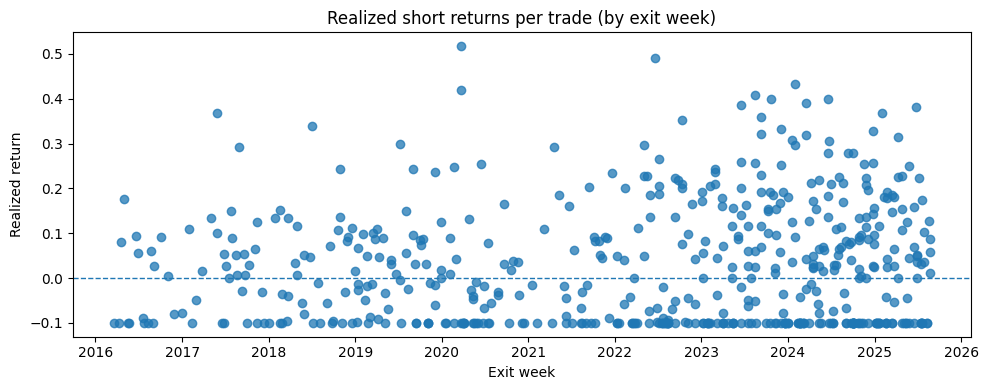

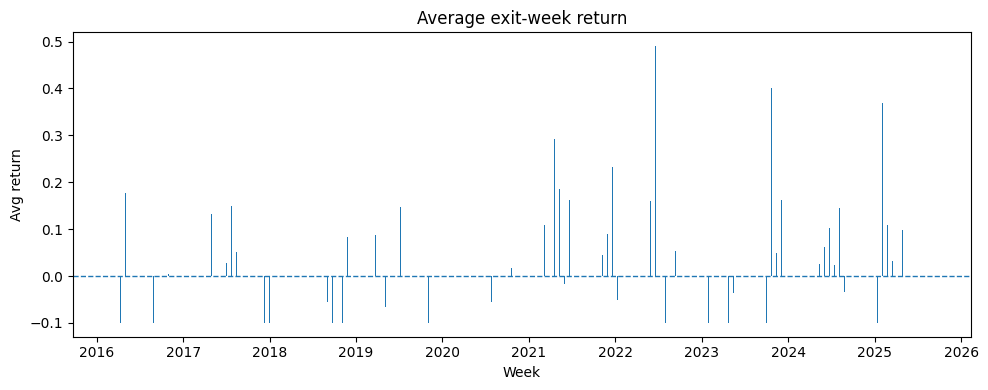

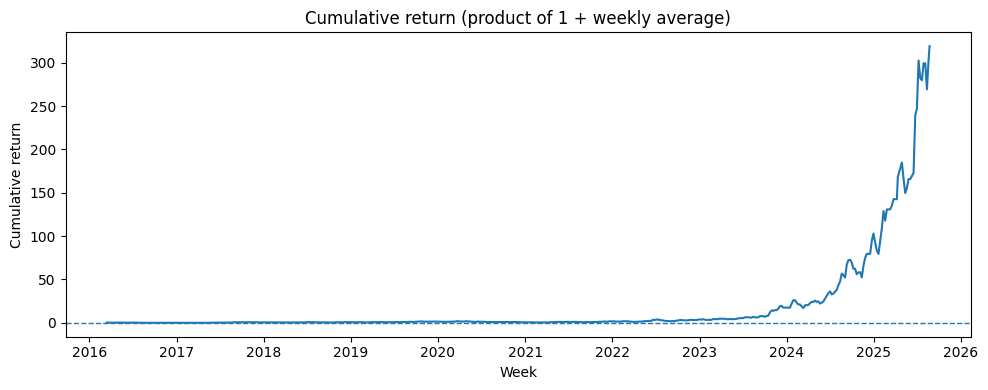

In [33]:
# ===== 3) PLOTS: per-trade returns, weekly averages, cumulative return =====
import matplotlib.pyplot as plt

if 'trades' not in globals() or trades.empty:
    raise ValueError("No trades to plot. Run the trading chunk first.")

# 1) Per-trade realized returns (scatter by exit week)
plt.figure(figsize=(10,4))
plt.scatter(trades["exit_date"], trades["realized_ret"], alpha=0.75)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Realized short returns per trade (by exit week)")
plt.xlabel("Exit week"); plt.ylabel("Realized return")
plt.tight_layout(); plt.show()

# 2) Weekly average exit returns (bar)
if 'weekly_full' not in globals() or weekly_full.empty:
    raise ValueError("Missing 'weekly_full'. Ensure the trading chunk ran successfully.")

plt.figure(figsize=(10,4))
plt.bar(weekly_full["date"], weekly_full["period_ret"])
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Average exit-week return")
plt.xlabel("Week"); plt.ylabel("Avg return")
plt.tight_layout(); plt.show()

# 3) Cumulative product of weekly averages (equity curve)
plt.figure(figsize=(10,4))
plt.plot(weekly_full["date"], weekly_full["cum_ret"])
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Cumulative return (product of 1 + weekly average)")
plt.xlabel("Week"); plt.ylabel("Cumulative return")
plt.tight_layout(); plt.show()

DATA SPAN:        2010-06-14 → 2025-08-22
Training ends:    2016-03-07 (TRAIN_WEEKS = 300)
Eligible start:   2016-03-14 (first week you’re allowed to enter)
First entry seen: 2018-02-05

Earliest week with selections: 2016-03-14

Reasons before 2021 (counts):
reason
traded    250

Top-10 feature missing rates before 2021 (for your ZCOLS):
Short Positions          0.0%
Total Volume             0.0%
Shorts (%)               0.0%
Date Free Float          0.0%
Shorts (Free Float %)    0.0%
dtype: object

First 12 eligible weeks (from trade start):
      week  n_total  n_feat_ok  max_prob      q80  prob_floor  strong_thr  n_selected reason
2016-03-14      198        198  0.565979 0.507832        0.55        0.95          40 traded
2016-03-18      201        201  0.565331 0.506346        0.55        0.95          41 traded
2016-03-28        3          3  0.500981 0.000000        0.55        0.95           3 traded
2016-04-04      198        198  0.565901 0.507307        0.55        0.95     

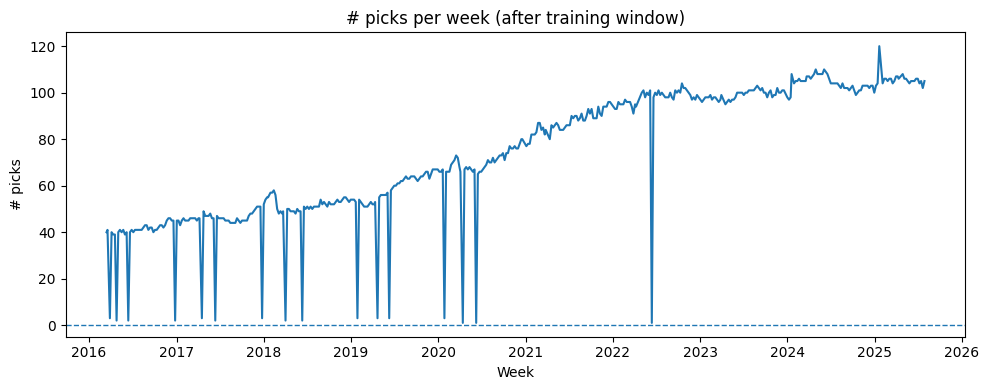

In [30]:
# Pull thresholds from globals if they exist (fallbacks match the "less strict" chunk)
TOP_QUANTILE   = globals().get("TOP_QUANTILE", 0.80)   # top 20%
PROB_FLOOR     = globals().get("PROB_FLOOR", 0.55)     # prob >= 0.55 passes
STRONG_THRESH  = globals().get("STRONG_THRESH", 0.85)  # very strong signals
# (STOP_LOSS doesn't affect *entries*, so it isn't used here)

# --- Safety: need the objects created by your training+trading chunks
for var in ["df","clf","ZCOLS","dates","H","TRAIN_WEEKS"]:
    if var not in globals():
        raise NameError(f"Missing '{var}'. Run the training chunk first.")

# Recompute/confirm these in case they’re not in scope
train_end_idx   = TRAIN_WEEKS - 1
train_end_date  = pd.to_datetime(dates[train_end_idx])
trade_start_idx = TRAIN_WEEKS
trade_start_date = pd.to_datetime(dates[trade_start_idx])

first_entry_date = None
if "trades" in globals() and isinstance(trades, pd.DataFrame) and not trades.empty:
    first_entry_date = pd.to_datetime(trades["entry_date"].min())

print("DATA SPAN:       ", pd.to_datetime(df["Date"].min()).date(), "→", pd.to_datetime(df["Date"].max()).date())
print("Training ends:   ", train_end_date.date(), f"(TRAIN_WEEKS = {TRAIN_WEEKS})")
print("Eligible start:  ", trade_start_date.date(), "(first week you’re allowed to enter)")
print("First entry seen:", first_entry_date.date() if first_entry_date is not None else "None")

# ---- Week-by-week diagnostics (from eligible start onward)
rows = []
for i in range(trade_start_idx, len(dates) - H):
    wk_date = pd.to_datetime(dates[i])

    # Universe this week
    test = df[df["Date"] == wk_date]
    n_total = len(test)

    n_feat_ok = 0
    n_selected = 0
    max_prob = np.nan
    q_thr = np.nan

    if n_total > 0:
        mask = np.isfinite(test[ZCOLS]).all(axis=1)
        after_feat = test.loc[mask]
        n_feat_ok = len(after_feat)

        if n_feat_ok > 0:
            probs = clf.predict_proba(after_feat[ZCOLS].values)[:, 1]
            max_prob = float(np.max(probs))
            q_thr = float(np.quantile(probs, TOP_QUANTILE)) if n_feat_ok >= 10 else 0.0
            selected = (probs >= q_thr) | (probs >= PROB_FLOOR) | (probs >= STRONG_THRESH)
            n_selected = int(np.sum(selected))

    # Reason classification
    if n_total == 0:
        reason = "no data this week"
    elif n_feat_ok == 0:
        reason = "all features NaN"
    elif n_selected == 0:
        # not selected despite data+features
        if np.isfinite(max_prob) and ((max_prob < q_thr) and (max_prob < PROB_FLOOR) and (max_prob < STRONG_THRESH)):
            reason = "probabilities below thresholds"
        else:
            reason = "filtered by thresholds"
    else:
        reason = "traded"

    rows.append({
        "week": wk_date,
        "n_total": n_total,
        "n_feat_ok": n_feat_ok,
        "max_prob": max_prob,
        f"q{int(TOP_QUANTILE*100)}": q_thr,
        "prob_floor": PROB_FLOOR,
        "strong_thr": STRONG_THRESH,
        "n_selected": n_selected,
        "reason": reason
    })

diag = pd.DataFrame(rows)

# ---- Where did trading actually begin?
first_trade_week = diag.loc[diag["n_selected"] > 0, "week"].min() if not diag.empty else None
print("\nEarliest week with selections:", first_trade_week.date() if pd.notna(first_trade_week) else "None")

# ---- Why only post-2021? Count reasons before 2021
pre_cut = pd.Timestamp("2021-01-01")
pre_diag = diag[diag["week"] < pre_cut]
if len(pre_diag):
    print("\nReasons before 2021 (counts):")
    print(pre_diag["reason"].value_counts().to_string())
    print("\nTop-10 feature missing rates before 2021 (for your ZCOLS):")
    miss_rates = df[df["Date"] < pre_cut][ZCOLS].isna().mean().sort_values(ascending=False)
    print((miss_rates.head(10) * 100).round(1).astype(str) + "%")
else:
    print("\nNo eligible weeks before 2021 after the training window.")

# ---- Quick table of the first 12 eligible weeks (to see why there were no trades)
print("\nFirst 12 eligible weeks (from trade start):")
print(diag.head(12).to_string(index=False))

# ---- Plot #picks per week so you can see when trading wakes up
plt.figure(figsize=(10,4))
plt.plot(diag["week"], diag["n_selected"])
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("# picks per week (after training window)")
plt.xlabel("Week"); plt.ylabel("# picks")
plt.tight_layout(); plt.show()


In [34]:
import pandas as pd
import numpy as np

# Require a trades DataFrame
if 'trades' not in globals() or trades is None or trades.empty:
    raise ValueError("`trades` is empty or missing. Run the trading chunk first.")

t = trades.copy()

# Clean types for consistent printing
for c in ["entry_date", "exit_date"]:
    if c in t.columns:
        t[c] = pd.to_datetime(t[c], errors="coerce")
for c in ["entry_price","exit_price","realized_ret","prob_down"]:
    if c in t.columns:
        t[c] = pd.to_numeric(t[c], errors="coerce")

# Preferred column order (use what exists)
preferred_cols = [
    "entry_date","exit_date","Ticker",
    "entry_price","exit_price","realized_ret",
    "prob_down","held_weeks","stopped_out"
]
cols = [c for c in preferred_cols if c in t.columns]

# Sort and take first 20
out = (t.sort_values(["entry_date","exit_date","Ticker"], na_position="last")
         .loc[:, cols]
         .head(20)
         .copy())

# Round numbers for readability
for c in ["entry_price","exit_price"]:
    if c in out: out[c] = out[c].round(4)
for c in ["realized_ret","prob_down"]:
    if c in out: out[c] = out[c].round(4)

print("\nFIRST 20 TRADES:\n")
print(out.to_string(index=False))



FIRST 20 TRADES:

entry_date  exit_date Ticker  entry_price  exit_price  realized_ret  prob_down  held_weeks  stopped_out
2016-03-14 2016-03-18    MYR        1.120      1.2320       -0.1000     0.5510           1         True
2016-03-14 2016-04-11    FMG        2.580      2.8380       -0.1000     0.5615           3         True
2016-03-14 2016-04-18    MTS        1.800      1.6550        0.0806     0.5660           4        False
2016-03-18 2016-05-02    MYR        1.240      1.0200        0.1774     0.5505           4        False
2016-04-18 2016-05-23    MTS        1.655      1.8205       -0.1000     0.5591           4         True
2016-05-02 2016-05-16    MYR        1.020      1.1220       -0.1000     0.5528           2         True
2016-05-16 2016-06-20    MYR        1.225      1.1100        0.0939     0.5572           4        False
2016-05-23 2016-06-27    MTS        1.955      1.8450        0.0563     0.5572           4        False
2016-06-20 2016-07-18    MYR        1.110    